In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from timm import create_model
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer

In [3]:
images_path = '../../data/resized_and_user_images'
labels_path = '../../data/resized_and_user_labels.csv'

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

In [5]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(224,224), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

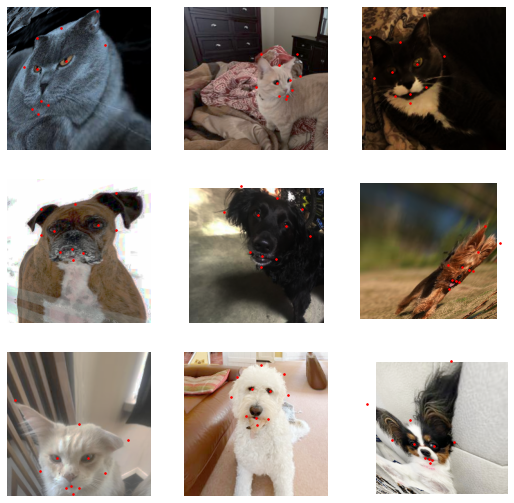

In [6]:
dls = dblock.dataloaders(images_path, bs=64)
dls.c = dls.train.after_item.c
dls.show_batch()

In [7]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, 
                        init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, **kwargs):
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=MSELossFlat(), opt_func=ranger, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [8]:
learn = timm_learner(dls, 'efficientnet_b3a')

In [9]:
learn.lr_find()

In [10]:
learn.fit_flat_cos(
    10, 
    3e-2,
    wd=0.1,
    cbs=[
        SaveModelCallback()
    ]
)

epoch,train_loss,valid_loss,time


In [10]:
learn.load('model')

In [11]:
learn.show_results()

In [27]:
learn.unfreeze()

In [28]:
frozen_params = filter(lambda p: not p.requires_grad, learn.model.parameters())
frozen_params = sum([np.prod(p.size()) for p in frozen_params])
unfrozen_params = filter(lambda p: p.requires_grad, learn.model.parameters())
unfrozen_params = sum([np.prod(p.size()) for p in unfrozen_params])
frozen_params, unfrozen_params


(0, 12287528)

In [29]:
learn.lr_find()

In [31]:
from bentoml.frameworks.fastai import FastaiModelArtifact
from bentoml.adapters import MultiImageInput

ModuleNotFoundError: No module named 'bentoml.frameworks'